In [101]:
# Code imports
from lib.opt_types import *
from lib.utils import *

# First Order Methods - 25 points

As a means of estimating the unknown parameter $\mathbf{x}^\natural$, your labor in part 1 led you to define the following optimization problem:
\begin{equation}
	\mathbf{x}^\star=\arg\min_{\mathbf{x} \in \mathbb{R}^p} f_\mu(\mathbf{x}) \equiv  f(\mathbf{x}) + \frac{\mu}{2}\|\mathbf{x}\|_2^2.
\tag{1}
\end{equation}

The optimality condition of (1) is

\begin{equation}
\nabla f_\mu({\mathbf x}^\star) = \sum_{i=1}^n -b_i \sigma(-b_i \cdot \mathbf{a}_i^T\mathbf{x}^\star)\mathbf{a}_i + \mu \mathbf{x}^\star = 0. \tag{2}
\end{equation}

Thanks to convexity, condition (2) is in fact the necessary and sufficient condition for $\mathbf x^\star$ to be optimal.
We can equivalently write this condition as
\begin{equation}
\mathbf x^\star = {\mathbf x}^\star - \mathbf{B} \nabla f_\mu({\mathbf x}^\star) \tag{3}
\end{equation}
for any symmetric, positive definite matrix $\mathbf{B}$. 
This is a fixed-point formulation of (1), which will be used to develop first-order methods.


Notice that choosing $\mathbf{B} = \alpha \mathbb{I}$ with $\alpha > 0$ in the formulation (3) suggests that the gradient descent method can be used to solve (1). 

In this part, you will implement different variants of the gradient descent algorithm. 


### Code structure:

A `Function` is a type that has the following attributes:

```python
@dataclass
class Function:
    f              # The function that is being minimized
    grad           # The gradient of the function
    f_star         # The minimum of the function
    strng_cvx      # The strong convexity constant, if it admits one
    lips_grad      # The smoothness constant, if it admits one
```

For a given function `f = Function()`:
- You can evaluate the function at a point `x` by simply writing `f(x)`.
- You can evaluate the gradient at a point `x` by writing `f.grad(x)`.
- You can get the smoothness constant by writing `f.lips_grad`.
- You can get the strong convexity constant by writing `f.strng_cvx`



We have defined the function that we are trying to minimize $f_\mu$ and stored in the object `f`, and we have provided you with an inital guess of a solution `x_zero`.

In [102]:
from lib.part_one import f, x_zero

In order for you to test your algorithms, we have also provided you with a `test` function that runs a given method on a strongly convex quadratic function $x \mapsto \frac{1}{2}x^\top M x$ for `100` iterations that we intialize at $x_0 = \begin{bmatrix} 100.0& 100.0 \end{bmatrix}$. For example, once you implement `GD` you can test it by running

```python
test(GD)
```

<div class="alert alert-block alert-success">
<b>Run the cells !</b> Make sure you run all the code cells as some variables are defined and used in mutiple subsequent cells.
</div>

### Variants of Gradient Descent

Now you will implement various methods to iteratively improve the initial guess `x_zero`.

__(a)__ (2 points) The main ingredients of the gradient descent algorithm are the descent direction (the negative gradient) and the step-size $\alpha_k$. 
In this part, we consider the gradient descent algorithm with constant step-size ${1}/{L}$, i.e., $\alpha_k = {1}/{L}$ for any $k = 0,1,...$ where $L$ is the gradient-Lipschitz constant of the function `f`. 

Gradient Descent, as an iterative scheme, only tracks the current iterate `x_k` and the step size `alpha_k`. We store them both in a state variable that holds both these attributes:

In [103]:
@dataclass
class GD_state(OptState):
    x_k: Vector
    alpha_k: float
    
    # allow tuple-unpacking: `x_k, alpha_k = state`
    def __iter__(self):
        yield self.x_k
        yield self.alpha_k

Given a function `f` and a state at some iteration $k$, recall how GD updates the state and fill in the following cell:

In [104]:
def GD_update(f, state):
    x_k, alpha_k = state
    # Gradient Descent update with constant step size alpha_k = 1 / L
    x_next = x_k - alpha_k * f.grad(x_k)
    return GD_state(x_k=x_next, alpha_k=alpha_k)

Having defined the `GD_update` which updates a given state, we now need to initialize the state. Fill in the cell below, recalling that you are given an initial guess `x_zero`, and the fact that we are using a fixed step size corresponding to the smoothness constant of `f`.

In [105]:
def GD_initialize(f, x_zero):
    x_k = x_zero
    # Fixed step size: alpha = 1 / L where L is the gradient Lipschitz constant
    alpha_k = 1.0 / f.lips_grad
    return GD_state(x_k, alpha_k)


With the initialization and the update scheme specified, we define the algorithm in the cell below:

In [106]:
GD = OptAlgorithm(name="GD", init_state = GD_initialize, state_update = GD_update)

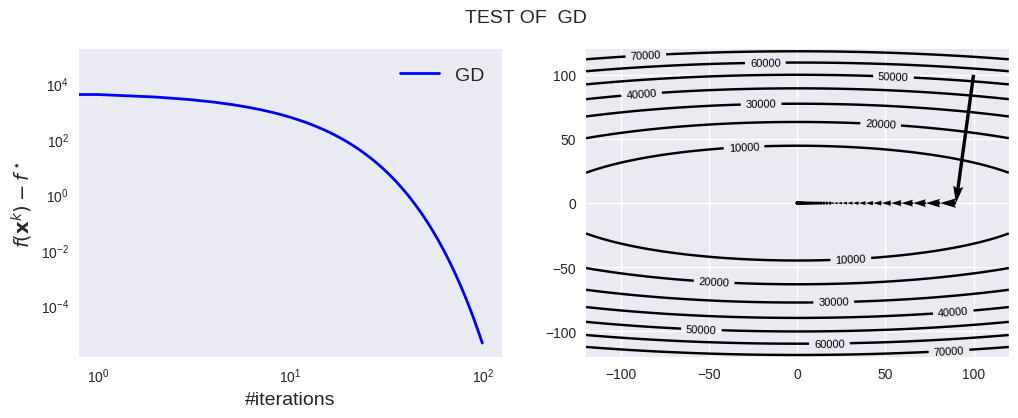

In [107]:
test(GD)

We now notice that the objective function is strongly convex. Therefore, we can select the constant step-size $\alpha$ as $2/(L+\mu)$ to get a faster convergence rate. We call this algorithm `GDstr`.

Both `GD` and `GDstr` have the same state update but only differ in the stepsize they use. Implement this variant of the gradient descent method by completing the code:

In [108]:
def GDstr_initialize(f, x_zero):
    x_k = x_zero
    # Faster constant step size for strongly convex case: 2 / (L + μ)
    alpha_k = 2.0 / (f.lips_grad + f.strng_cvx)
    return GD_state(x_k, alpha_k)

GDstr = OptAlgorithm(name="GDstr", init_state=GDstr_initialize, state_update=GD_update)


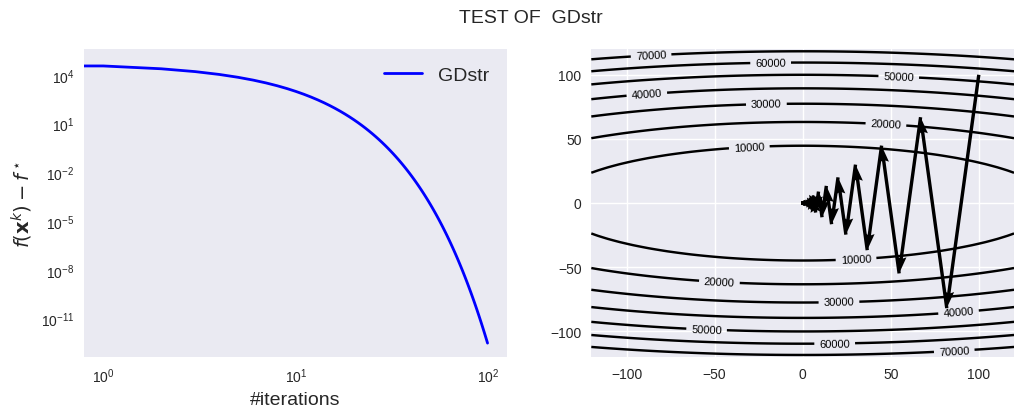

In [109]:
test(GDstr)

__(b-1)__ (1.5 points) We can accelerate the above gradient descent algorithm with the following scheme ($t_0=1$):

\begin{equation*}
\begin{array}{ll}
\mathbf{x}^{k+1} &:=  \mathbf{y}^k - \alpha_k\nabla{f_\mu}(\mathbf{y}^k),\\
t_{k+1} &:= \frac{1}{2}(1 + \sqrt{1 + 4t_k^2})\\
\mathbf{y}^{k+1} &:= \mathbf{x}^{k+1} + \frac{t_k-1}{t_{k+1}}\big(\mathbf{x}^{k+1} - \mathbf{x}^k\big).
\end{array}
\end{equation*}

Implement this algorithm with constant step-size $\alpha = 1/L$, by completing the missing parts of the following cells.

First we define the state that the algorithm updates at each iteration:

In [110]:
@dataclass
class AGD_state(OptState):
    x_k: Vector
    y_k: Vector
    t_k: float
    alpha_k: float

Given this `state` and a function `f` to optimize, write the update step of accelerated gradient descent:

In [111]:
def AGD_update(f, state):
    x_k, y_k, t_k, alpha_k = state

    # x^{k+1} = y^k - α_k ∇f(y^k)
    next_x_k = y_k - alpha_k * f.grad(y_k)

    # t_{k+1} = 0.5 * (1 + sqrt(1 + 4 t_k^2))
    next_t_k = 0.5 * (1.0 + (1.0 + 4.0 * (t_k ** 2)) ** 0.5)

    # y^{k+1} = x^{k+1} + (t_k / t_{k+1}) * (x^{k+1} - x^k)
    next_y_k = next_x_k + (t_k / next_t_k) * (next_x_k - x_k)

    # Constant step size α = 1 / L
    next_alpha_k = alpha_k

    return AGD_state(x_k=next_x_k, y_k=next_y_k, t_k=next_t_k, alpha_k=next_alpha_k)


Define the initial state of AGD in the cell below:

In [112]:
def AGD_initialize(f, x_zero):
    # Start from x0 with t0 = 1 and constant α = 1/L
    return AGD_state(x_k=x_zero, y_k=x_zero, t_k=1.0, alpha_k=1.0 / f.lips_grad)

We have all the necessary ingredients to define the optimization algorithm in the following cell:

In [113]:
AGD = OptAlgorithm(name="AGD", init_state=AGD_initialize, state_update=AGD_update)

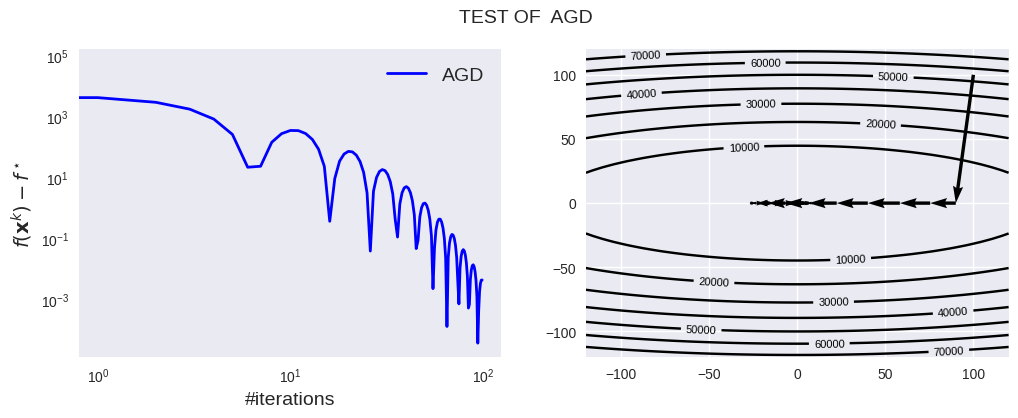

In [114]:
test(AGD)

__(b-2)__ (1 points)

Note that the objective function is strongly convex. Therefore, we can use the accelerated gradient algorithm for strongly convex objectives to converge faster. This variant can be summarized as follows:

\begin{equation*}
\left\{\begin{array}{ll}
\mathbf{x}^{k+1} &:=  \mathbf{y}^k - \alpha_k\nabla{f_\mu}(\mathbf{y}^k),\\
\mathbf{y}^{k+1} &:= \mathbf{x}^{k+1} + m\big(\mathbf{x}^{k+1} - \mathbf{x}^k\big).
\end{array}\right. 
\end{equation*}
 
Implement this variant of the accelerated gradient method by completing the following cells. Try different values of $m$ and comment on what should be the best value for this constant. Do the practical results follow the theory?

In [115]:
@dataclass
class AGDstr_state(OptState):
    x_k: Vector
    y_k: Vector
    alpha_k: float
    m_strongcvx: float

In [116]:
def AGDstr_update(f, state):
    x_k, y_k, alpha_k, m_strongcvx = state

    # x^{k+1} = y^k - α_k ∇f(y^k)
    next_x_k = y_k - alpha_k * f.grad(y_k)
    # y^{k+1} = x^{k+1} + m (x^{k+1} - x^k)
    next_y_k = next_x_k + m_strongcvx * (next_x_k - x_k)

    return AGDstr_state(next_x_k, next_y_k, alpha_k, m_strongcvx)


def AGDstr_initialize(f, x_zero):
    # Theoretical optimal momentum for strong convexity:
    # m = (sqrt(L) - sqrt(μ)) / (sqrt(L) + sqrt(μ))
    L = f.lips_grad
    mu = f.strng_cvx
    m_strongcvx = (L**0.5 - mu**0.5) / (L**0.5 + mu**0.5)
    x_k = x_zero
    y_k = x_zero
    alpha_k = 1.0 / L
    return AGDstr_state(x_k, y_k, alpha_k, m_strongcvx)


In [117]:
AGDstr = OptAlgorithm(name="AGDstr", init_state=AGDstr_initialize, state_update=AGDstr_update)

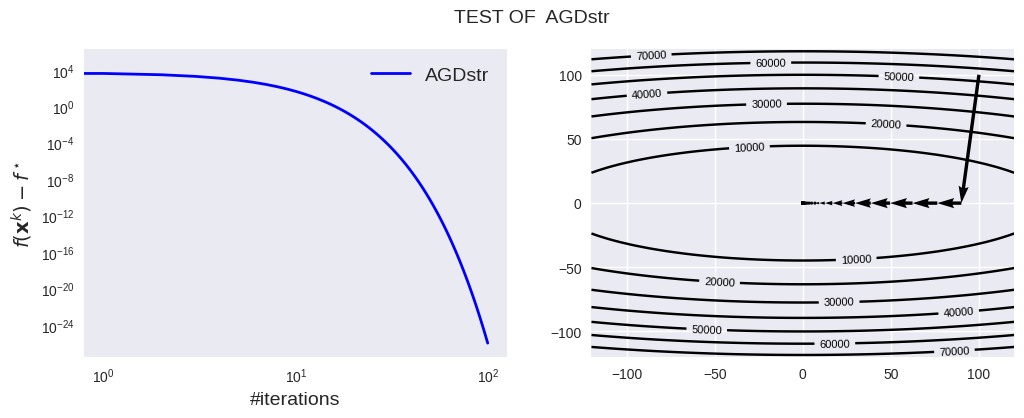

In [118]:
test(AGDstr)

__(c)__ (4 points) We can obtain better performance by considering a line search procedure, which adapts the step-size $\alpha_k$ to the local geometry. 
The line-search strategy to determine the step-size $\alpha_k$ for the standard GD algorithm,
$\mathbf{x}^{k+1}=\mathbf{x}^k-\alpha_k\nabla f_\mu(\mathbf{x}^k),$
is the following: 

At the step $kth$ iteration, let $\mathbf{x}^k$ be the current iterate and $\mathbf{d}^k=-\nabla f_\mu(\mathbf{x}^k)$ be a given descent direction, and perform:
* Set $L_0 = L$.
* At each iteration, set $L_{k,0} = \frac{1}{2}L_{k-1}$, where $k$ is the iteration counter. 
* Using a for loop, find the minimum integer $i \geq 0$ that satisfies $f_\mu\left(\mathbf{x}^k + \frac{1}{2^i L_{k,0}} \mathbf{d}^k\right) \leq f_\mu(\mathbf{x}^k) -\frac{1}{2^{i+1} L_{k,0}} \|\mathbf{d}^k\|^2$.
* Set $L_k = {2^i L_{k,0}}$ and use the step-size $\alpha_k := \frac{1}{L_k}$ (i.e., use the new estimate that you have used in the line-search: $\mathbf{x}^k + \frac{1}{2^i L_{k,0}} \mathbf{d}^k$).

Complete the missing parts in order to implement gradient descent with line-search.

In [119]:
@dataclass
class LS_GD_state(OptState):
    x_k: Vector
    L_k: float
    alpha_k: float

In [120]:
def LS_GD_update(f, state):
    x_k, L_prev, _ = state

    # Descent direction
    d_k = -f.grad(x_k)
    d_sq = d_k @ d_k
    f_xk = f(x_k)

    # Start line search from half the previous Lipschitz estimate
    L_cand = 0.5 * L_prev if L_prev > 0 else f.lips_grad

    # Backtracking to find smallest i >= 0 s.t.
    # f(x_k + (1/L) d_k) <= f(x_k) - (1/(2L)) ||d_k||^2
    while True:
        alpha = 1.0 / L_cand
        x_trial = x_k + alpha * d_k
        if f(x_trial) <= f_xk - 0.5 * alpha * d_sq:
            break
        L_cand *= 2.0  # increase L (smaller step) until condition holds

    x_next = x_trial
    L_next = L_cand
    alpha_next = alpha
    return LS_GD_state(x_next, L_next, alpha_next)

def LS_GD_initialize(f, x_zero):
    L0 = f.lips_grad  # initial Lipschitz estimate
    return LS_GD_state(x_zero, L0, 1.0 / L0)

In [121]:
LS_GD = OptAlgorithm(name="LS_GD", init_state = LS_GD_initialize, state_update=LS_GD_update )

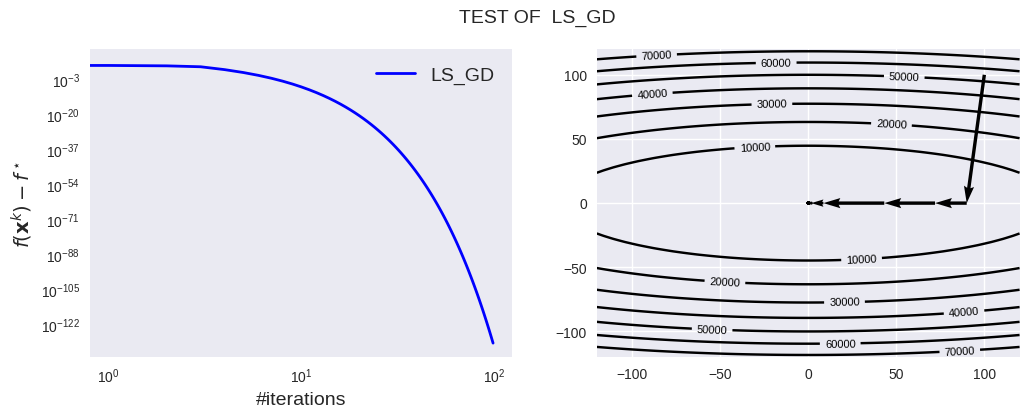

In [122]:
test(LS_GD)

We now incorporate a line-search enhancement to the accelerated gradient method implemented in (b). At step $k$, 
we have the current iteration $\mathbf{x}^k$ together with an _intermediate variable_ $\mathbf{y}^k$ and its corresponding direction $\mathbf{d}^k=-\nabla f_\mu(\mathbf{y}^k)$. **Note that the intermediate variable is then used in the gradient step and hence the line-search will be performed on it to determine the step-size**.


Perform a line-search strategy with respect to $\mathbf{y}^k$ and direction $\mathbf{d}^k$ to determine the step-size $\alpha_k$ as follows:

* Set $L_0 = L$.
* At each iteration, set $L_{k,0} = \frac{1}{2}L_{k-1}$, where $k$ is the iteration counter. 
* Using a for loop, find the minimum integer $i \geq 0$ that satisfies $f_\mu\left(\mathbf{y}^k + \frac{1}{2^i L_{k,0}} \mathbf{d}^k\right) \leq f_\mu(\mathbf{y}^k) -\frac{1}{2^{i+1} L_{k,0}} \|\mathbf{d}^k\|^2$.
* Set $L_k = {2^i L_{k,0}}$ and use the step-size $\alpha_k := \frac{1}{L_k}$.
 
Update the next iterations:
\begin{equation*}
\left\{\begin{array}{ll}
\mathbf{x}^{k+1} &:=  \mathbf{y}^k - \alpha_k\nabla{f_\mu}(\mathbf{y}^k),\\
t_{k+1} &:= \frac{1}{2}\left(1 + \sqrt{1 + 4\frac{L_k}{L_{k-1}}t_k^2}\right)\\
\mathbf{y}^{k+1} &:= \mathbf{x}^{k+1} + \frac{t_k-1}{t_{k+1}}\big(\mathbf{x}^{k+1} - \mathbf{x}^k\big).
\end{array}\right.
\end{equation*}

Complete the missing parts in order to implement accelerated gradient descent with line-search.

In [123]:
@dataclass
class LS_AGD_state(OptState):
    x_k: Vector
    y_k: Vector
    t_k: float
    L_k: float
    alpha_k: float

In [124]:
def LS_AGD_update(f, state):
    x_k, y_k, t_k, L_prev, _ = state

    # Direction and function value at y^k
    d_k = -f.grad(y_k)
    d_sq = d_k @ d_k
    f_yk = f(y_k)

    # Start backtracking from half the previous Lipschitz estimate
    L_cand = 0.5 * L_prev if L_prev > 0 else f.lips_grad

    # Line-search on y^k: find smallest i ≥ 0 such that
    # f(y^k + (1/L) d^k) ≤ f(y^k) − (1/(2L)) ||d^k||^2
    while True:
        alpha = 1.0 / L_cand
        x_trial = y_k + alpha * d_k
        if f(x_trial) <= f_yk - 0.5 * alpha * d_sq:
            break
        L_cand *= 2.0

    # Accept step
    x_next = x_trial
    L_next = L_cand
    alpha_next = alpha

    # FISTA-style momentum with varying L:
    t_next = 0.5 * (1.0 + (1.0 + 4.0 * (L_prev / L_next) * (t_k ** 2)) ** 0.5)

    # Extrapolation
    y_next = x_next + (t_k / t_next) * (x_next - x_k)

    return LS_AGD_state(x_next, y_next, t_next, L_next, alpha_next)

def LS_AGD_initialize(f, x_zero):
    L0 = f.lips_grad
    return LS_AGD_state(x_k=x_zero, y_k=x_zero, t_k=1.0, L_k=L0, alpha_k=1.0 / L0)


In [125]:
LS_AGD = OptAlgorithm(name="LS_AGD", init_state=LS_AGD_initialize, state_update=LS_AGD_update )#FILL

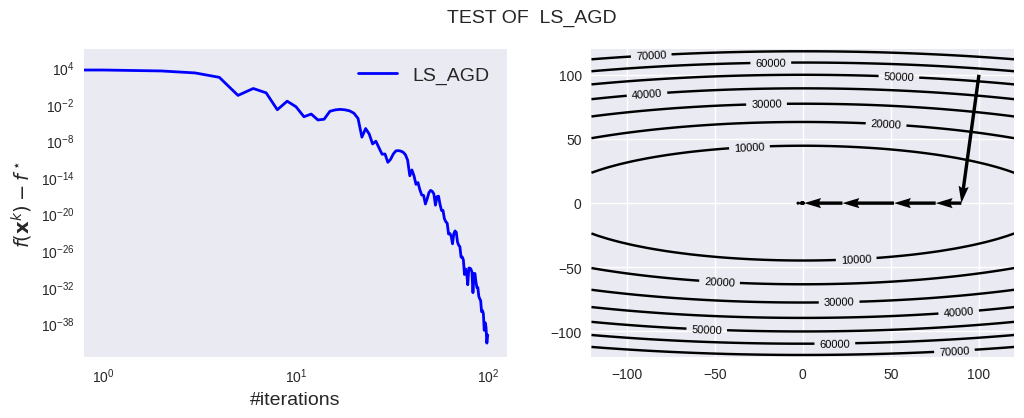

In [126]:
test(LS_AGD)

__(d)__ (3 points) The accelerated gradient method is non-monotonic, so it can be oscillatory, i.e. $f_\mu(\mathbf{x}^{k+1})\not\leq f_\mu(\mathbf{x}^k)$ for all $k\geq 0$.
To prevent such behavior, we can use the so-called adaptive restart strategy. 
In short, this strategy can be explained as follows: 
At each iteration, whenever $\mathbf{x}^{k+1}$ is computed, we evaluate $f_\mu(\mathbf{x}^{k+1})$ and compare it with $f_\mu(\mathbf{x}^k)$: 

* If $f_\mu(\mathbf{x}^k) < f_\mu(\mathbf{x}^{k+1})$, restart the iteration, i.e., recompute $\mathbf{x}^{k+1}$ by setting $\mathbf{y}^{k} := \mathbf{x}^{k}$ and $t_{k} := 1$;
* Otherwise, let the algorithm continue.


This strategy requires the evaluation of the function value at each iteration, which increases the computational complexity of the overall algorithm. 

Implement the adaptive restart strategy which uses the function values for the accelerated gradient algorithm with constant step-size $\alpha_k=1/L$ 
by completing the function:

In [127]:
@dataclass
class AGDR_state(AGD_state):
    pass

In [128]:
def AGDR_update(f, state):
    x_k, y_k, t_k, alpha_k = state

    # Candidate AGD step using y^k
    x_cand = y_k - alpha_k * f.grad(y_k)

    # Adaptive restart based on function values
    if f(x_k) < f(x_cand):
        # Restart: set y^k := x^k and t_k := 1, then recompute the step
        y_k = x_k
        t_k = 1.0
        x_next = y_k - alpha_k * f.grad(y_k)
        t_next = 0.5 * (1.0 + (1.0 + 4.0 * (t_k ** 2)) ** 0.5)
        y_next = x_next + (t_k / t_next) * (x_next - x_k)
    else:
        # Accept candidate and proceed with standard AGD update
        x_next = x_cand
        t_next = 0.5 * (1.0 + (1.0 + 4.0 * (t_k ** 2)) ** 0.5)
        y_next = x_next + (t_k / t_next) * (x_next - x_k)

    return AGDR_state(x_next, y_next, t_next, alpha_k)

AGDR_initialize = AGD_initialize

In [129]:
AGDR = OptAlgorithm(name="AGDR", init_state = AGDR_initialize, state_update=AGDR_update)

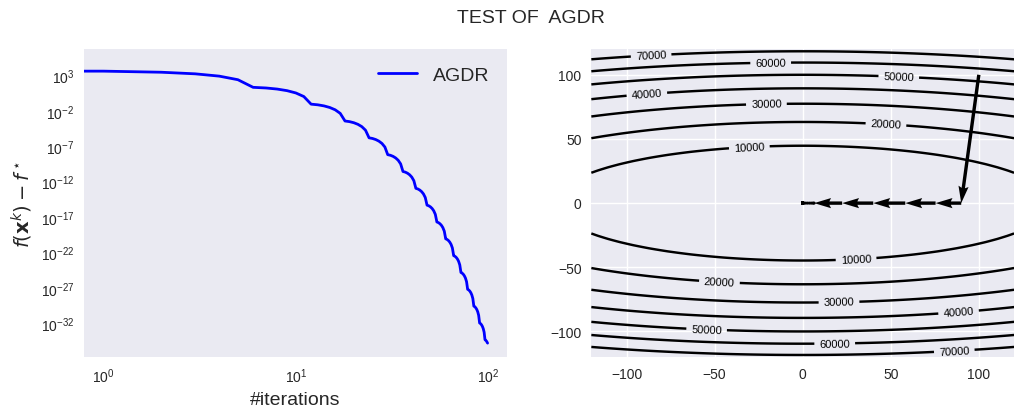

In [130]:
test(AGDR)

__(e)__ (Self-study, 0 points)
Incorporate the line-search, acceleration and function values restart by completing the function LSAGDR. 

**Hint:** Note that while the restart is executed on $\mathbf{x}^k$, the line-search strategy is executed on $\mathbf{y}^k$ and the direction $\mathbf{d}^k=-\nabla f(\mathbf{y}^k)$ to determine the 
step-size and hence, use line-search each time you encounter an intermediate variable $\mathbf{y}^k$.

In [131]:
@dataclass
class LS_AGDR_state(LS_AGD_state):
    # Same fields as LS_AGD_state: x_k, y_k, t_k, L_k, alpha_k
    pass

In [132]:
def LS_AGDR_update(f, state):
    x_k, y_k, t_k, L_prev, _ = state

    def line_search_at(y, L_start):
        d = -f.grad(y)
        d_sq = d @ d
        f_y = f(y)
        L_cand = 0.5 * L_start if L_start > 0 else f.lips_grad
        while True:
            alpha = 1.0 / L_cand
            x_trial = y + alpha * d
            if f(x_trial) <= f_y - 0.5 * alpha * d_sq:
                return x_trial, L_cand, alpha
            L_cand *= 2.0

    # 1) Line-search step using y^k
    x_candidate, L_ls, alpha_ls = line_search_at(y_k, L_prev)

    # 2) Function-value restart check on x^k vs x^{k+1}
    if f(x_k) < f(x_candidate):
        # restart: set y^k := x^k and t_k := 1, then redo the line-search
        y_k = x_k
        t_k = 1.0
        x_next, L_next, alpha_next = line_search_at(y_k, L_prev)
    else:
        x_next, L_next, alpha_next = x_candidate, L_ls, alpha_ls

    # 3) Acceleration with varying L (FISTA-style)
    t_next = 0.5 * (1.0 + (1.0 + 4.0 * (L_prev / L_next) * (t_k ** 2)) ** 0.5)
    y_next = x_next + (t_k / t_next) * (x_next - x_k)

    return LS_AGDR_state(x_next, y_next, t_next, L_next, alpha_next)


def LS_AGDR_initialize(f, x_zero):
    L0 = f.lips_grad
    return LS_AGDR_state(x_k=x_zero, y_k=x_zero, t_k=1.0, L_k=L0, alpha_k=1.0 / L0)

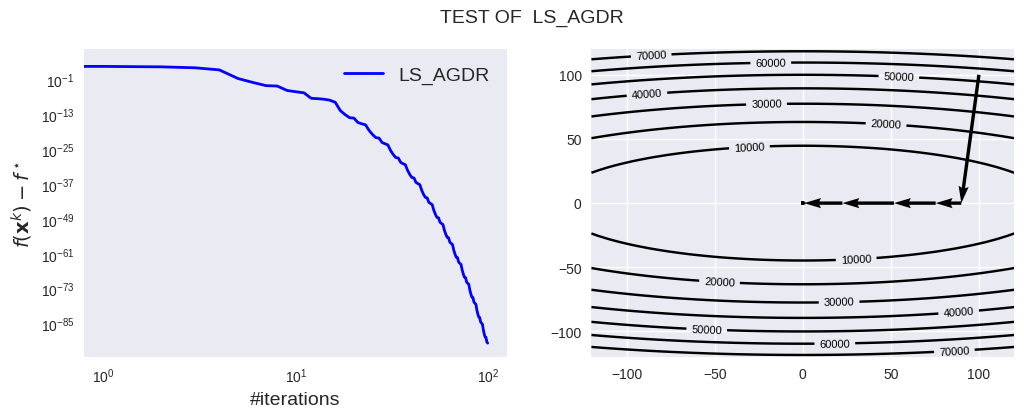

In [133]:
LS_AGDR = OptAlgorithm(name="LS_AGDR", init_state=LS_AGDR_initialize, state_update=LS_AGDR_update)

test(LS_AGDR)

__(f)__ (4 points) We can also apply an optimization technique that does not exploit the knowledge of the Lipschitz constant, and instead adapts to the local geometry by making use of past gradient information. AdaGrad adapts the step-size using the inverse square $\ell_2$-norm of past gradients. Starting with $Q_0 = 0$ it iterates as follows:

\begin{equation*}
\left\{\begin{array}{ll}
Q_k &{\!\!\!\!}= Q_{k-1} + \|\nabla f_\mu(\mathbf{x}^k)\|^2 \\
\mathbf{H}_k &{\!\!\!\!}= (\sqrt{Q_k} + \delta) I \\
\mathbf{x}^{k+1} &{\!\!\!\!}= \mathbf{x}^k - \alpha \mathbf{H}_k^{-1} \nabla f_\mu(\mathbf{x}^k)
\end{array}\right.
\end{equation*}

Complete the missing parts in the function AdaGrad in order to implement the above adaptive gradient method using $\alpha = 1$, $\delta = 10^{-5}$.

In [134]:
@dataclass
class AdaGrad_state(OptState):
    x_k: Vector
    Q_k: float
    alpha_k: float
    delta: float

In [135]:
def AdaGrad_update(f, state):
    x_k, Q_k, alpha_k, delta = state

    g_k = f.grad(x_k)
    Q_next = Q_k + (g_k @ g_k)  # accumulate squared gradient norms
    step = alpha_k / (Q_next ** 0.5 + delta)

    x_next = x_k - step * g_k
    return AdaGrad_state(x_next, Q_next, alpha_k, delta)

def AdaGrad_initialize(f, x_zero):
    return AdaGrad_state(x_k=x_zero, Q_k=0.0, alpha_k=1.0, delta=1e-5)


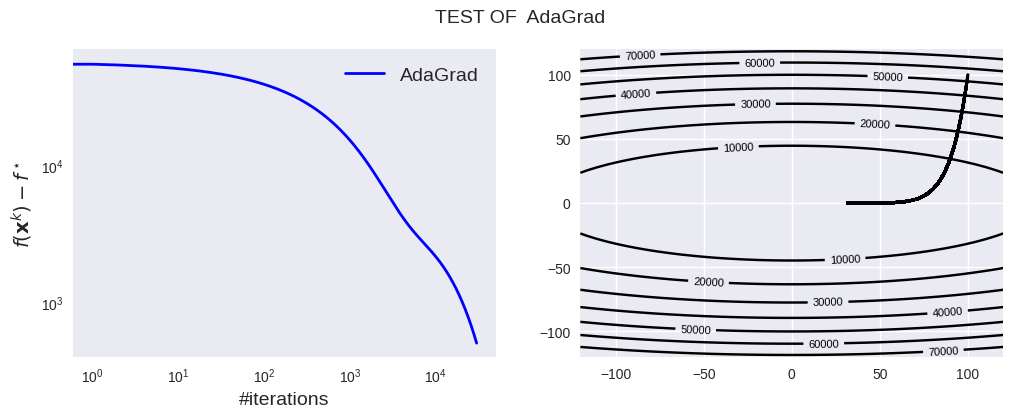

In [136]:
AdaGrad = OptAlgorithm(name="AdaGrad", init_state=AdaGrad_initialize, state_update=AdaGrad_update)
test(AdaGrad, maxiter=30000)

__(g)__ (2.5 points) Another famous adaptive optimization method is called the ADAptive Moment estimation algorithm, also known as ADAM, 

\begin{equation*}
\left\{\begin{array}{ll}
\mathbf{g}_k &{\!\!\!\!} = \nabla f_\mu(\mathbf{x}^{k}) \\
\mathbf{m}_{k+1} &{\!\!\!\!} = \beta_1 \mathbf{m}_{k} + (1-\beta_1)\mathbf{g}_k \ \textrm{$\leftarrow$ Momentum}\\
\mathbf{v}_{k+1} &{\!\!\!\!} = \beta_2 \mathbf{v}_{k} + (1-\beta_2)\mathbf{g}_k^2 \ \textrm{$\leftarrow$ Adaptive term}\\
\hat{\mathbf{m}}_{k+1} &{\!\!\!\!} = \mathbf{m}_{k+1} / (1-\beta_1^{k+1})\\
\hat{\mathbf{v}}_{k+1} &{\!\!\!\!} = \mathbf{v}_{k+1} / (1-\beta_2^{k+1}) \ \textrm{$\leftarrow$ Scaling for removing bias}\\
\mathbf{H}_{k+1} &{\!\!\!\!} \ = \sqrt{\hat{\mathbf{v}}_{k+1}} + \epsilon \\
\mathbf{x}^{k+1} &{\!\!\!\!} = \mathbf{x}^k - \alpha \hat{\mathbf{m}}_{k+1} / \mathbf{H}_{k+1}
\end{array}\right.
\end{equation*}

Note that all operations shown above, when applied to vectors, are applied element-wise. In particular, $\mathbf{g}_k^2$ is a vector of the same size as $\mathbf{g}_k$ where each element is squared.

Complete the missing parts in the cells below in order to implement the above adaptive gradient method using $\alpha = 0.1$, $\beta_1 = 0.9$, $\beta_2 = 0.999$ and $\epsilon = 10^{-8}$.

It has been shown that ADAM can fail to converge to the global minimum of a convex problem. The authors provided a variant of ADAM, called AMSgrad in order to fix this convergence issue. However, in practice it is not clear which method performs best. (You are not required to implement this method, but advised to have a look at it for personal interest).

In [137]:
@dataclass
class ADAM_state(OptState):
    x_k: Vector
    m_k: Vector
    v_k: Vector
    t_k: int
    alpha_k: float
    beta1: float
    beta2: float
    eps: float

In [138]:
def ADAM_update(f, state):
    x_k, m_k, v_k, t_k, alpha_k, beta1, beta2, eps = state

    g_k = f.grad(x_k)
    m_next = beta1 * m_k + (1.0 - beta1) * g_k
    v_next = beta2 * v_k + (1.0 - beta2) * (g_k * g_k)  # element-wise square

    t_next = t_k + 1
    m_hat = m_next / (1.0 - (beta1 ** t_next))
    v_hat = v_next / (1.0 - (beta2 ** t_next))

    x_next = x_k - alpha_k * m_hat / (np.sqrt(v_hat) + eps)

    return ADAM_state(x_next, m_next, v_next, t_next, alpha_k, beta1, beta2, eps)

def ADAM_initialize(f, x_zero):
    alpha = 0.1
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8
    m0 = np.zeros_like(x_zero)
    v0 = np.zeros_like(x_zero)
    return ADAM_state(x_zero, m0, v0, 0, alpha, beta1, beta2, eps)


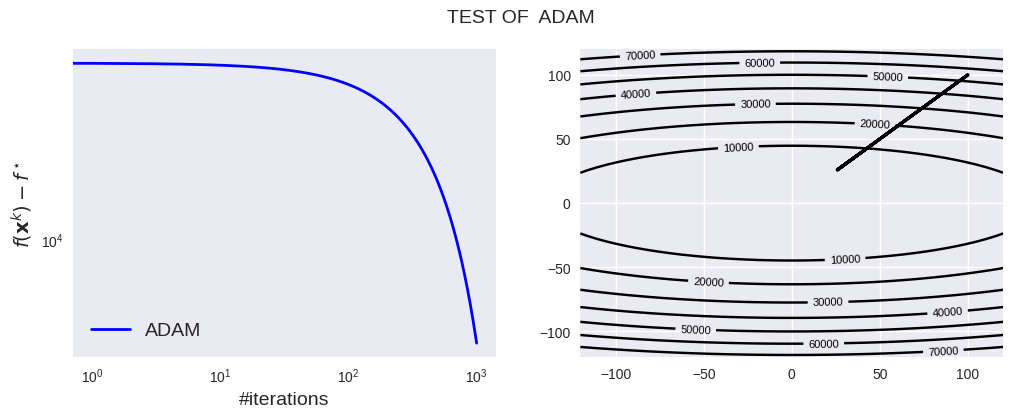

In [139]:
ADAM = OptAlgorithm(name="ADAM", init_state=ADAM_initialize, state_update=ADAM_update)

test(ADAM, maxiter=1000)

## Scheduler Free Optimizer

Schedule-Free learning replaces the momentum of an underlying optimizer with a combination of interpolation and averaging. In the case of gradient descent, the basic Schedule-Free update is:

$$
\begin{align*}
y_{t} & = (1-\beta)z_{t} + \beta x_{t},\\
z_{t+1} & =z_{t}-\gamma\nabla f(y_{t}),\\
x_{t+1} & =\left(1-\frac{1}{t+1}\right)x_{t}+\frac{1}{t+1}z_{t+1},
\end{align*}
$$

Here $x$ is the sequence that evaluations of test/val loss should occur at, which differs from the primary iterates $z$ and the gradient evaluation locations $y$. The updates to $z$ correspond to the underlying optimizer, in this case a simple gradient step.

As the name suggests, Schedule-Free learning does not require a decreasing learning rate schedule, yet typically out-performs, or at worst matches, SOTA schedules such as cosine-decay and linear decay. Only two sequences need to be stored at a time (the third can be computed from the other two on the fly) so this method has the same memory requirements as the base optimizer (parameter buffer + momentum). You can set $\gamma$ to 0.1.




In [140]:
@dataclass
class Scheduler_free_state(OptState):
    x_k: Vector      # primary iterate
    z_k: Vector      # auxiliary iterate
    t_k: int         # iteration counter (starts at 0)
    beta: float      # interpolation coefficient β
    gamma: float     # gradient step size γ


**(a)** (1 points) Fill the initializer for the scheduler free optimizer, build the scheduler free optimizer main update state.

In [141]:
def Scheduler_free_update(f, state):
    x_k, z_k, t_k, beta, gamma = state

    # Interpolate to get the evaluation point
    y_k = (1.0 - beta) * z_k + beta * x_k

    # Underlying optimizer step on z using gradient at y
    z_next = z_k - gamma * f.grad(y_k)

    # Averaging step to form the primary iterate
    t_next = t_k + 1
    x_next = (1.0 - 1.0 / t_next) * x_k + (1.0 / t_next) * z_next

    return Scheduler_free_state(x_next, z_next, t_next, beta, gamma)


def Scheduler_free_initialize(f, x_zero):
    # Reasonable defaults
    beta = 0.5
    gamma = 0.1
    return Scheduler_free_state(x_k=x_zero, z_k=x_zero, t_k=0, beta=beta, gamma=gamma)


**(b)** (1 points) Run your experiment and discuss why the algorithm is referred to as a scheduler-free optimizer. For reference, it is beneficial to review [Road Less Scheduled](https://arxiv.org/abs/2405.15682)
 to gain a deeper understanding of the concepts and rationale behind this terminology.

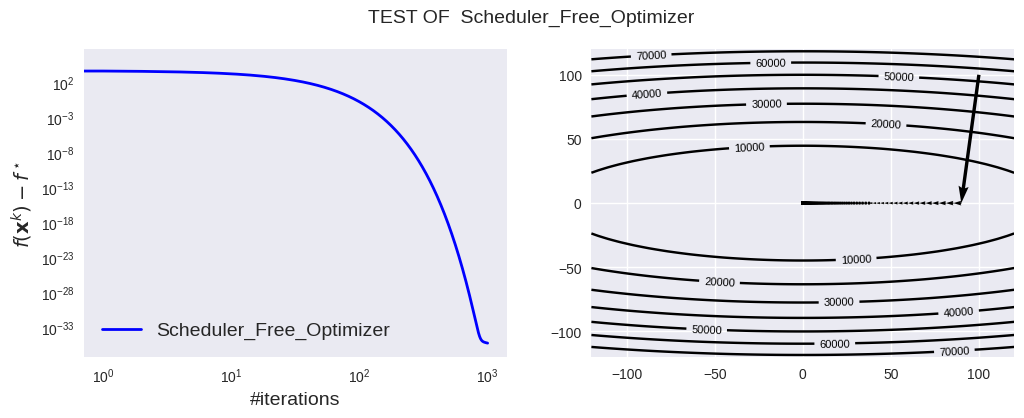

In [142]:
SFO = OptAlgorithm(name="Scheduler_Free_Optimizer", init_state=Scheduler_free_initialize, state_update=Scheduler_free_update)

test(SFO, maxiter=1000)

With the initializer from (a) (e.g., $\gamma=0.1$, $\beta=0.5$), the update we
tested is $y_k=(1-\beta)z_k+\beta x_k$, $z_{k+1}=z_k-\gamma\nabla f(y_k)$, and
$x_{k+1}=(1-\frac{1}{t_k+1})x_k+\frac{1}{t_k+1}z_{k+1}$. In the experiment, the
suboptimality $f(x_k)-f^*$ drops smoothly over $\sim10^3$ iterations and the
trajectory to the minimizer is well-damped, without the large zig-zags typical
of plain gradient descent on ill-conditioned problems. The key point is that we
never change the base stepsize $\gamma$: there is no step, cosine, or linear
decay to tune. Instead, the algorithm achieves the stabilizing effect of a
schedule implicitly. First, gradients are evaluated at the blended point $y_k$,
which already moderates oscillations across curved directions. Second, the
averaging that forms $x_{k+1}$ uses the automatically shrinking weight
$1/(t_k+1)$, so the influence of each new step on $x$ decays over time; this
acts like an “on-the-fly” annealing even though $\gamma$ is fixed. Practically,
this yields the same behavior that hand-crafted learning-rate schedules aim for,
fast early progress followed by increasing stability, while avoiding brittle
schedule hyperparameters. Memory/compute overhead matches the base optimizer
because only $x$ and $z$ are stored and $y$ is formed on the fly. In short, the
method is called a scheduler-free optimizer because it delivers schedule-like
performance and convergence dynamics without any external learning-rate
schedule; the interpolation plus harmonic averaging provide the effect
automatically.

## Polyak’s Heavy Ball (PHB) Method

Polyak’s Heavy Ball (PHB) method accelerates gradient descent by adding momentum, modeling a ball rolling over the objective landscape with friction. The continuous-time form is

$$
\ddot{\mathbf{x}} = -a\,\nabla f(\mathbf{x}) - b\,\dot{\mathbf{x}},
$$

where $a$ controls attraction to the minimum and $b$ provides damping.

The discrete update is

$$
\mathbf{x}_{k+1} = \mathbf{x}_k - \alpha\,\nabla f_\mu(\mathbf{x}_k) + \beta\,(\mathbf{x}_k - \mathbf{x}_{k-1}),
$$

with step size $\alpha$ and momentum $\beta$.

For an $L$-smooth, $\mu$-strongly convex $f$, choosing

$$
\alpha = \frac{4}{(\sqrt{L}+\sqrt{\mu})^2}, \qquad 
\beta = \left(\frac{\sqrt{\kappa}-1}{\sqrt{\kappa}+1}\right)^2, \quad \kappa = \frac{L}{\mu},
$$

gives the linear rate

$$
\|\mathbf{x}_k - \mathbf{x}^*\| \le 
\left(\frac{\sqrt{\kappa}-1}{\sqrt{\kappa}+1}\right)^k
\|\mathbf{x}_0 - \mathbf{x}^*\|.
$$

This momentum-driven scheme reduces oscillations and speeds convergence compared to plain gradient descent, with the same memory footprint (current and previous iterates).

We'll implement PHB with a state that stores the current iterate, the previous iterate, and the scalars $\alpha$ and $\beta$. 


**(a)** (1 points) Fill the initializer and update for the polyak's heavy ball optimizer.

In [143]:
@dataclass
class PHB_state(OptState):
    x_k: Vector        # current iterate
    x_prev: Vector     # previous iterate
    alpha_k: float     # step size α
    beta_k: float      # momentum β


In [144]:
def PHB_update(f, state):
    x_k, x_prev, alpha, beta = state
    g = f.grad(x_k)
    x_next = x_k - alpha * g + beta * (x_k - x_prev)
    # shift: current becomes previous
    return PHB_state(x_k=x_next, x_prev=x_k, alpha_k=alpha, beta_k=beta)


def PHB_initialize(f, x_zero):
    # Optimal parameters for L-smooth, μ-strongly convex objectives
    L = f.lips_grad
    mu = f.strng_cvx
    sL, smu = L ** 0.5, mu ** 0.5
    alpha = 4.0 / (sL + smu) ** 2
    kappa = L / mu
    beta = ((kappa ** 0.5 - 1.0) / (kappa ** 0.5 + 1.0)) ** 2

    # Start with x_{-1} = x_0
    return PHB_state(x_k=x_zero, x_prev=x_zero, alpha_k=alpha, beta_k=beta)

**(b)** (1 points) Test the polyak's heavy ball optimizer.

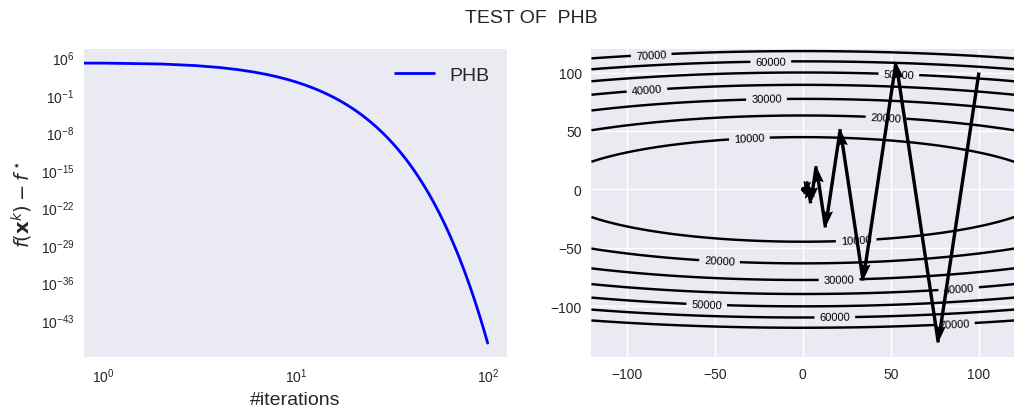

In [145]:
PHB = OptAlgorithm(name="PHB", init_state=PHB_initialize, state_update=PHB_update)

test(PHB)

## NAG-Free Adaptive Acceleration

NAG-Free accelerates gradient descent by **adapting Nesterov’s method** without requiring prior knowledge of smoothness ($L$) or strong convexity ($\mu$) and without using restarts. Instead, it continuously **estimates** these parameters from recent iterates and gradients.

The method keeps the familiar Nesterov structure but updates its coefficients online:

$$
\begin{aligned}
\mathbf{x}_{k+1} &= \mathbf{y}_k - \tfrac{1}{L_k}\nabla f(\mathbf{y}_k),\\[4pt]
\mathbf{y}_{k+1} &= \mathbf{x}_{k+1} + a_k\,(\mathbf{x}_{k+1}-\mathbf{x}_k),
\end{aligned}
$$

where

- $L_k$ is an on-the-fly estimate of the local Lipschitz constant of $\nabla f$,
- $a_k$ is the momentum parameter computed from current $L_k$ and an adaptive estimate of $\mu$, and
- only one extra iterate and gradient are stored to maintain these estimates.

When $f$ is $L$-smooth and $\mu$-strongly convex, the adaptive rules recover the classical accelerated rate

$$
\|\mathbf{x}_k - \mathbf{x}^*\| \le 
\left(\frac{\sqrt{\kappa}-1}{\sqrt{\kappa}+1}\right)^k
\|\mathbf{x}_0 - \mathbf{x}^*\|,\qquad \kappa=L/\mu,
$$

**without knowing $L$ or $\mu$ in advance and without any scheduled restarts**.

This restart-free, parameter-free scheme guarantees at least the convergence speed of gradient descent on general convex problems and automatically achieves Nesterov-style acceleration whenever local strong convexity is present, while requiring only minimal extra memory.

**(a)** (1 point) Complete the cells below to define the state, update rule, initializer, and algorithm object.


In [146]:
@dataclass
class NAGfree_state(OptState):
    # current iterate (x_k) and extrapolated point (y_k)
    x_k: Vector
    y_k: Vector

    # previous extrapolated point and its gradient (for curvature estimates)
    y_prev: Vector
    g_prev: Vector

    # online coefficient estimates and momentum
    L_k: float       # local smoothness estimate
    mu_hat: float    # strong-convexity estimate (nonincreasing)
    a_k: float       # momentum parameter used to form y_{k+1}


In [147]:
def NAGfree_update(f, state):
    x_k, y_k, y_prev, g_prev, L_k, mu_hat, a_k = (
        state.x_k, state.y_k, state.y_prev, state.g_prev, state.L_k, state.mu_hat, state.a_k
    )

    # Gradient at the extrapolated point
    g_k = f.grad(y_k)

    # --- Update the local curvature estimates from secant information ---
    s = y_k - y_prev          # displacement
    y = g_k - g_prev          # gradient displacement
    eps = 1e-12
    sTs = float(s @ s)

    if sTs > eps:
        # Secant Rayleigh quotients (both lie in [mu, L] for SPD/convex problems)
        rq = max(float(s @ y) / (sTs + eps), 0.0)              # ~ local curvature
        rq2 = max(float(y @ y) / (float(s @ y) + eps), 0.0)    # slightly more conservative

        # Keep L nondecreasing; keep mu nonincreasing and <= L
        L_new = max(L_k, rq, rq2, eps)
        mu_new = min(mu_hat, rq, L_new)
    else:
        # If we have no displacement, keep estimates as-is
        L_new, mu_new = max(L_k, eps), max(min(mu_hat, L_k), 0.0)

    # Step and momentum (reduce to GD when mu_new ~ 0)
    alpha = 1.0 / L_new
    tau = (mu_new / L_new) ** 0.5 if mu_new > 0.0 else 0.0
    a_new = (1.0 - tau) / (1.0 + tau) if tau > 0.0 else 0.0

    # NAG-style update
    x_next = y_k - alpha * g_k
    y_next = x_next + a_new * (x_next - x_k)

    return NAGfree_state(
        x_k=x_next,
        y_k=y_next,
        y_prev=y_k,
        g_prev=g_k,
        L_k=L_new,
        mu_hat=mu_new,
        a_k=a_new,
    )


In [148]:
def NAGfree_initialize(f, x_zero):
    # Start with y_0 = x_0, a_0 = 0 (no momentum),
    # and neutral curvature guesses (no prior L or mu needed).
    g0 = f.grad(x_zero)
    L0 = 1.0                      # harmless default; will be adapted immediately
    mu0 = L0                      # ensures a_0 = 0 initially
    a0 = 0.0

    return NAGfree_state(
        x_k=x_zero,
        y_k=x_zero,
        y_prev=x_zero,
        g_prev=g0,
        L_k=L0,
        mu_hat=mu0,
        a_k=a0,
    )

**(b)** (1 point) Test the NAG-Free adaptive acceleration.

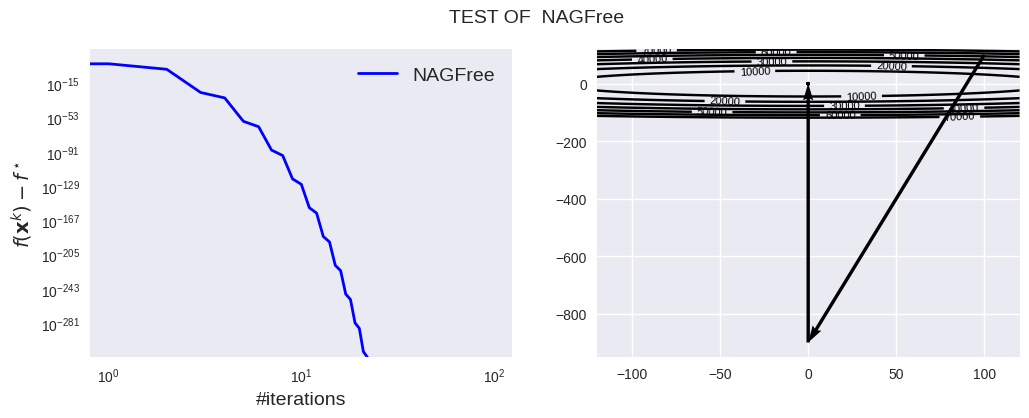

In [149]:
NAGFree = OptAlgorithm(name="NAGFree", init_state=NAGfree_initialize, state_update=NAGfree_update)


test(NAGFree)

## Running the methods - 1 Point


With these iterative shemes implemented, we will try to solve one logistic regression problem.

We are going to model the probablity that a basketball shot succesfully enters the net using the logistic model introduced in the first part of the homework.

Our data originates from motion tracking data captured by the NBA during the 2015-2016 season.

<img width=50% src='lib/golden_state_shots.png'/>

We consider the `3376` shots made by the Golden State Warriors. The labels ${b}_i$ will correspond to whether or not the shot $i$ was succesful, and $\mathbf{a}_i$ will be a feature vector of dimension 5 containing the x-location, the y-location (of the player shooting on the basketball court), the distance to the basket, the number of minutes and the number of seconds left before the end of the quarter.

The following cell runs the methods you have implemented on the logistic loss:

NAGFree: 100%|██████████| 5000/5000 [00:00<00:00, 9016.26it/s]


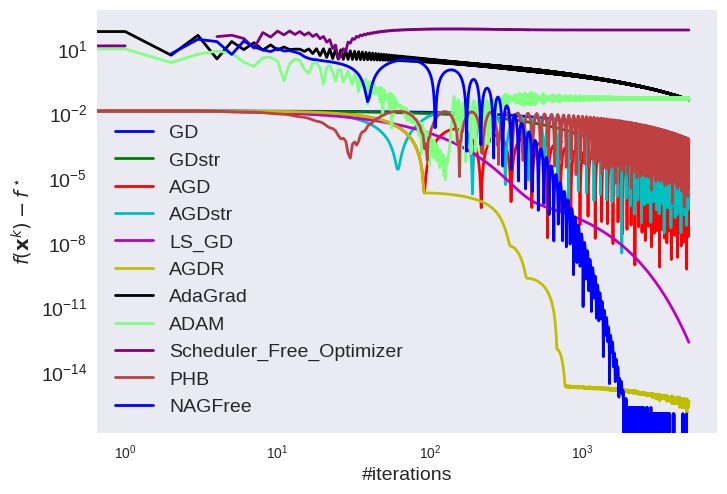

In [150]:
from lib.part_one import f, x_zero, train_accuracy

#Remove methods you have not implemented
methods = [GD, GDstr, AGD, AGDstr, LS_GD, AGDR, AdaGrad, ADAM, SFO, PHB, NAGFree]

plot(methods, f, x_zero, max_iteration=5000)

Now, think you are an NBA team general manager and you have access to the data described above for the 2015-2016 season. You want to pick a good performing method to predict the scoring efficiency of opposite teams - in order to adjust your team accordingly. Run the fillowing cell to display the training accuracy of your solution:

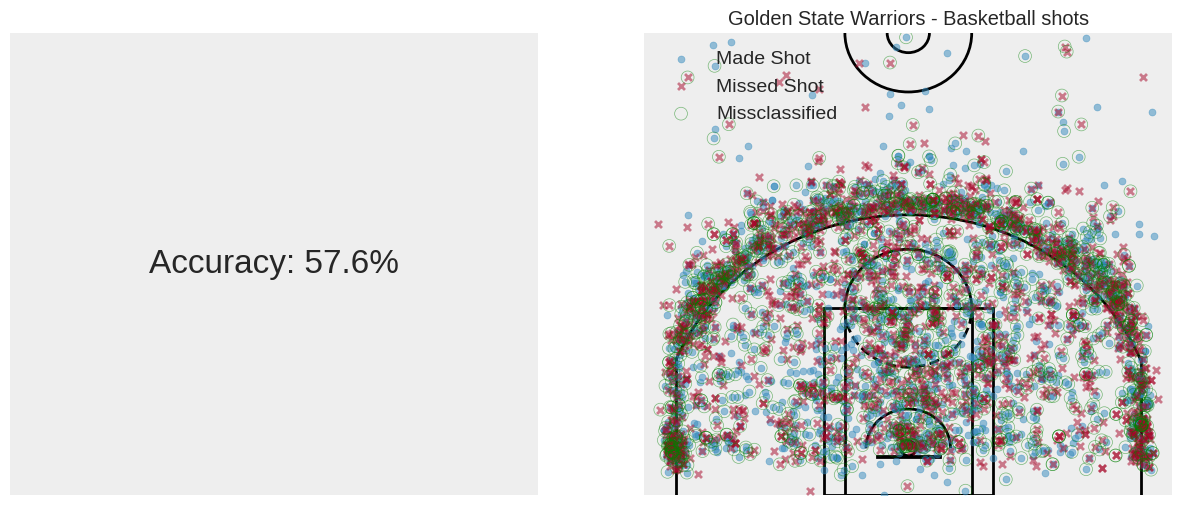

In [152]:
method = NAGFree
run_trace = run(method, f, x_zero, 5000)
last_x_k = run_trace.sequence[-1]

train_accuracy(run_trace.sequence[-1])


Given we have access to as many as `84467` distinct shots from all teams that played in 2015-2016, what could we do to improve our method? What consequences could that bring when running our deterministic methods? 

Use the larger dataset to build a stronger model: train on all 84,467 shots, add richer features (e.g., distance/angle, shot type, time/score context, player/team IDs, interactions), and apply regularization with cross-validation.  
But with this scale, **deterministic full-batch methods** (GD/AGD/PHB/NAG-Free) become impractical: each iteration costs O(n) to compute a full gradient and any line search repeats that cost-so wall-clock time explodes and restarts/acceleration give diminishing returns.  
Switch to **mini-batch / stochastic** optimization (SGD, Adam, or variance-reduced SVRG/SAGA) with batches (≈256-2048), learning-rate schedules, and early stopping. Expect non-monotone, noisy objective traces but far faster progress per second and better generalization. Also mitigate distribution shift by including team/player indicators or reweighting.
